In [1]:
import os
#os.chdir("./PycharmProjects/one-shot-face-recognition")
import torch
import torch.nn as nn
import torch
import time
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from tqdm import tqdm
from torch.utils.data import DataLoader
from utils import (
    non_max_suppression,
    mean_average_precision,
    intersection_over_union,
    cellboxes_to_boxes,
    get_bboxes,
    plot_image,
    save_checkpoint,
    load_checkpoint,
    get_face,
    get_face2,
    face_verification
)
from loss import YoloLoss
from model import Yolov1, SiameseNetwork
from dataset import Compose
from PIL import Image
import torchvision
import numpy as np
from torchvision import datasets, models
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [2]:
# yolo_model = Yolov1(split_size=7, num_boxes=2, num_classes=2)
# siamese_model = SiameseNetwork()
# yolo_optimizer = optim.Adam(
#         yolo_model.parameters(), lr=1e-5
# )
# siamese_optimizer = optim.Adam(
#     siamese_model.parameters(), lr=1e-4
# )

In [3]:
fasterRCNN_model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = fasterRCNN_model.roi_heads.box_predictor.cls_score.in_features  # we need to change the head
n_classes = 3
fasterRCNN_model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(
    in_features, n_classes)
siamese_model = SiameseNetwork()
params = [p for p in fasterRCNN_model.parameters() if p.requires_grad]
fasterRCNN_optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, nesterov=True, weight_decay=1e-4)
siamese_optimizer = optim.Adam(siamese_model.parameters(), lr=1e-4)

/Users/eugenekim/opt/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/eugenekim/opt/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# checkpoint = torch.load("load_models/YOLOv1.pth.tar", map_location=torch.device("cpu"))
# start_epoch = load_checkpoint(checkpoint, yolo_model, yolo_optimizer)
# checkpoint = torch.load("load_models/siamese.pth.tar", map_location=torch.device("cpu"))
# start_epoch = load_checkpoint(checkpoint, siamese_model, siamese_optimizer)

In [5]:
checkpoint = torch.load("load_models/fasterRCNN.pth.tar", map_location=torch.device("cpu"))
fasterRCNN_model.load_state_dict(checkpoint["state_dict"])
fasterRCNN_optimizer.load_state_dict(checkpoint["optimizer"])
checkpoint = torch.load("load_models/siamese.pth.tar", map_location=torch.device("cpu"))
start_epoch = load_checkpoint(checkpoint, siamese_model, siamese_optimizer)

=> Loading checkpoint


In [6]:
# group_photo = "graphs_and_charts/example.png"
# image = Image.open(group_photo).convert("RGB")
# transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor()])
# image, _ = transform(image, [])
# please = torch.unsqueeze(image,0)
# out = yolo_model(please)

In [7]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

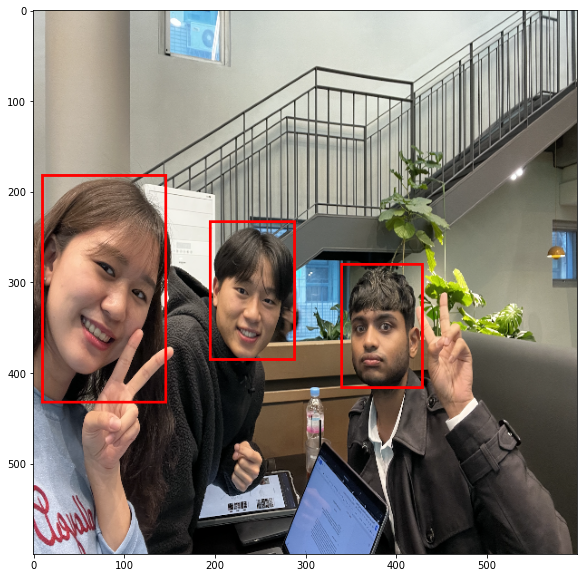

In [8]:
fasterRCNN_model.eval()
group_photo = "graphs_and_charts/example.png"
image = cv2.imread(group_photo, cv2.IMREAD_UNCHANGED)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
transform = get_transforms(train=False)
transformed = transform(image=image, bboxes=[])
image = (transformed["image"]).div(255)
with torch.no_grad():
    prediction = fasterRCNN_model([image])
    pred = prediction[0]
image = image.clone().detach() * 255
image = image.to(torch.uint8)
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(image,
    pred['boxes'][pred['scores'] > 0.8], width=3, colors="red"
).permute(1, 2, 0))

In [9]:
# bboxes = cellboxes_to_boxes(out)
# bboxes = non_max_suppression(bboxes[0], iou_threshold=0.5,
#                              threshold=0.95, box_format="midpoint")
# plot_image(image.permute(1, 2, 0).to("cpu"), bboxes)

In [10]:
pred["boxes"][pred["scores"] > 0.8]

tensor([[194.9459, 232.8110, 289.4904, 386.6909],
        [339.2563, 279.6600, 430.3441, 417.0547],
        [  9.3291, 181.8840, 147.3266, 433.9918]])

In [11]:
pred

{'boxes': tensor([[194.9459, 232.8110, 289.4904, 386.6909],
         [339.2563, 279.6600, 430.3441, 417.0547],
         [  9.3291, 181.8840, 147.3266, 433.9918],
         [337.5724, 281.8028, 432.1735, 419.1431],
         [  8.6981, 193.4519, 153.9580, 439.7660],
         [194.1134, 234.1460, 294.9198, 389.3542],
         [296.1942, 421.3633, 325.4659, 482.1649]]),
 'labels': tensor([2, 2, 2, 1, 1, 1, 1]),
 'scores': tensor([0.9961, 0.9462, 0.8350, 0.7405, 0.6821, 0.5312, 0.0791])}

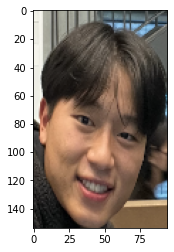

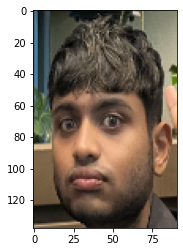

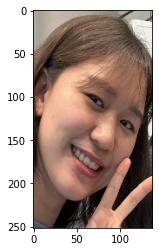

In [12]:
folder = "support_set"
get_face2(image.permute(1,2,0), pred["boxes"][pred["scores"] > 0.8], folder)

In [13]:
# folder = "support_set"
# get_face(image.permute(1,2,0), bboxes, folder)

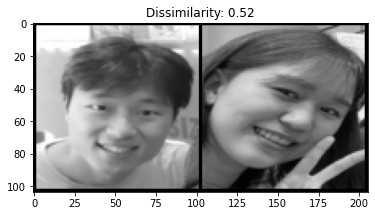

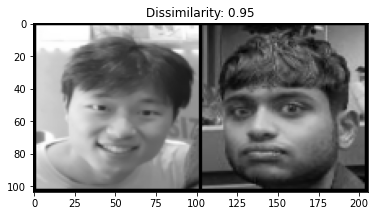

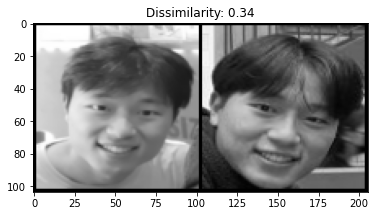

In [32]:
query_image = "query_image/query3.jpg"
support_set = "support_set"
transform = transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()])
lowest_score, lowest_idx = face_verification(query_image, support_set, transform, siamese_model)

In [29]:
# final = np.expand_dims(bboxes[lowest_idx], 0)
# plot_image(image.permute(1, 2, 0).to("cpu"), final)

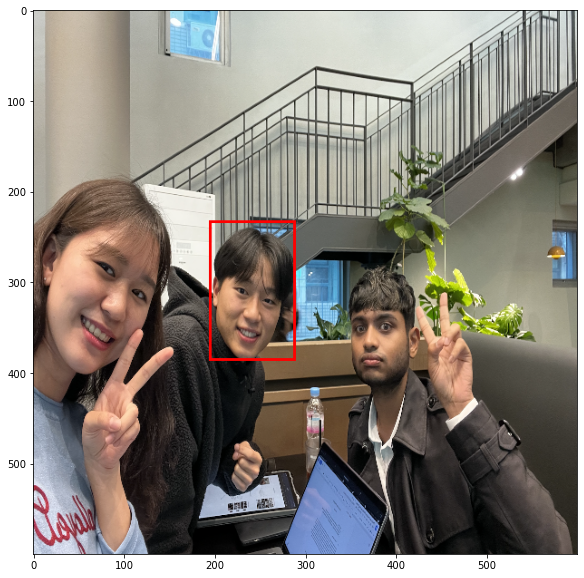

In [30]:
final = torch.unsqueeze(pred["boxes"][lowest_idx], 0)
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(image,
    final, width=3, colors="red"
).permute(1, 2, 0))